In [1]:
import intake
import matplotlib.pyplot as plt
import cftime
import numpy as np
import pandas as pd
import xarray as xr
import os

col_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)

In [2]:
query = col.search(
    experiment_id="historical",  
    table_id="SImon",            
    variable_id="siconc"         
)

print(query.df.head())

  activity_id institution_id  source_id experiment_id member_id table_id  \
0        CMIP      NOAA-GFDL  GFDL-ESM4    historical  r3i1p1f1    SImon   
1        CMIP      NOAA-GFDL  GFDL-ESM4    historical  r3i1p1f1    SImon   
2        CMIP      NOAA-GFDL  GFDL-ESM4    historical  r2i1p1f1    SImon   
3        CMIP      NOAA-GFDL  GFDL-ESM4    historical  r2i1p1f1    SImon   
4        CMIP      NOAA-GFDL   GFDL-CM4    historical  r1i1p1f1    SImon   

  variable_id grid_label                                             zstore  \
0      siconc         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...   
1      siconc         gr  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...   
2      siconc         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...   
3      siconc         gr  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...   
4      siconc         gr  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   

   dcpp_init_year   version  
0             NaN  20180701  
1       

In [20]:
ensemble_count = query.df.groupby('source_id')['member_id'].count()

ensemble_count_df = ensemble_count.reset_index()
ensemble_count_df.columns = ['Model', 'Number of Ensembles']

filter_df = ensemble_count_df[ensemble_count_df['Number of Ensembles'] >= 10]

sort_df = filter_df.sort_values(by='Number of Ensembles', ascending=False)

print(sort_df)

            Model  Number of Ensembles
23      EC-Earth3                   73
18        CanESM5                   65
44     MIROC-ES2L                   62
45         MIROC6                   50
1   ACCESS-ESM1-5                   40
41   IPSL-CM6A-LR                   32
51        NorCPM1                   30
33    GISS-E2-1-H                   25
15     CNRM-CM6-1                   21
56    UKESM1-0-LL                   17
7           CESM2                   11
49     MRI-ESM2-0                   11
39      INM-CM5-0                   10
47  MPI-ESM1-2-HR                   10
48  MPI-ESM1-2-LR                   10


In [3]:
chosen_model = "MPI-ESM1-2-LR"

filtered_ensembles = query.df[query.df['source_id'] == chosen_model][['source_id', 'member_id']]

print(filtered_ensembles)

         source_id  member_id
172  MPI-ESM1-2-LR  r10i1p1f1
177  MPI-ESM1-2-LR   r1i1p1f1
178  MPI-ESM1-2-LR   r8i1p1f1
179  MPI-ESM1-2-LR   r4i1p1f1
181  MPI-ESM1-2-LR   r3i1p1f1
182  MPI-ESM1-2-LR   r6i1p1f1
183  MPI-ESM1-2-LR   r5i1p1f1
184  MPI-ESM1-2-LR   r2i1p1f1
185  MPI-ESM1-2-LR   r7i1p1f1
186  MPI-ESM1-2-LR   r9i1p1f1


In [5]:
dset_dict = {}

for _, row in query.df.iterrows():
    model_key = f"CMIP.{row['institution_id']}.{row['source_id']}.{row['experiment_id']}.{row['table_id']}.{row['grid_label']}"
    dataset_url = row['zstore']  

    try:
        ds = xr.open_zarr(dataset_url, consolidated=True)
        dset_dict[model_key] = ds
    except Exception as e:
        print(f"Failed to load dataset {model_key}: {e}")

print(f"Loaded datasets: {list(dset_dict.keys())}")
print(dset_dict.keys())

Loaded datasets: ['CMIP.NOAA-GFDL.GFDL-ESM4.historical.SImon.gn', 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.SImon.gr', 'CMIP.NOAA-GFDL.GFDL-CM4.historical.SImon.gr', 'CMIP.NOAA-GFDL.GFDL-CM4.historical.SImon.gn', 'CMIP.IPSL.IPSL-CM6A-LR.historical.SImon.gn', 'CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.SImon.gn', 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.SImon.gn', 'CMIP.MIROC.MIROC6.historical.SImon.gn', 'CMIP.NCAR.CESM2-WACCM.historical.SImon.gn', 'CMIP.NCAR.CESM2.historical.SImon.gn', 'CMIP.SNU.SAM0-UNICON.historical.SImon.gn', 'CMIP.NASA-GISS.GISS-E2-1-H.historical.SImon.gr', 'CMIP.CCCma.CanESM5.historical.SImon.gn', 'CMIP.CCCma.CanESM5-CanOE.historical.SImon.gn', 'CMIP.INM.INM-CM4-8.historical.SImon.gr1', 'CMIP.INM.INM-CM5-0.historical.SImon.gr1', 'CMIP.HAMMOZ-Consortium.MPI-ESM-1-2-HAM.historical.SImon.gn', 'CMIP.NUIST.NESM3.historical.SImon.gn', 'CMIP.CAMS.CAMS-CSM1-0.historical.SImon.gn', 'CMIP.MPI-M.MPI-ESM1-2-LR.historical.SImon.gn', 'CMIP.MPI-M.MPI-ESM1-2-HR.historical.SImon.gn', 'CM

In [6]:
chosen_model = "MRI-ESM2-0"

# filter df for source_id
filter_model = query.df[query.df['source_id'] == chosen_model]

siconc_data = {}

for _, row in filter_model.iterrows():
    member_id = row['member_id']
    dataset_url = row['zstore']

    print(f"Processing member_id: {member_id}")

    try:
        ds = xr.open_zarr(dataset_url, consolidated=True)

        # time filter
        time = ds['time'].data
        if isinstance(time[0], cftime.datetime):
            time_mask = time >= cftime.DatetimeNoLeap(2000, 1, 1)
        else:
            time_mask = time >= np.datetime64('2000-01-01')

        ds_filtered_time = ds.sel(time=time_mask)

        # latitude variable
        if 'lat' in ds.coords:
            lat = ds['lat']
        elif 'latitude' in ds.coords:
            lat = ds['latitude']
        elif 'nav_lat' in ds.coords:
            lat = ds['nav_lat']
        else:
            print(f"No latitude variable found for {member_id}. Skip.")
            continue

        # latitude mask
        mask = (lat >= 75).compute()
        ds_north_75 = ds_filtered_time.where(mask, drop=True)

        if 'siconc' in ds_north_75.data_vars:
            if {'j', 'i'}.issubset(ds_north_75.dims):
                spatial_dims = ['j', 'i']
            elif {'y', 'x'}.issubset(ds_north_75.dims):
                spatial_dims = ['y', 'x']

            siconc_mean = ds_north_75['siconc'].mean(dim=spatial_dims)

            # store in dictionary
            siconc_series = siconc_mean.to_series()
            siconc_data[member_id] = siconc_series
        else:
            print(f"'siconc' not found in {member_id}. Skip.")

    except Exception as e:
        print(f"Failed to process {member_id}: {e}")

Processing member_id: r1i1p1f1
Processing member_id: r5i1p1f1
Processing member_id: r2i1p1f1
Processing member_id: r3i1p1f1
Processing member_id: r4i1p1f1
Processing member_id: r1i2p1f1
Processing member_id: r6i1p1f1
Processing member_id: r7i1p1f1
Processing member_id: r8i1p1f1
Processing member_id: r9i1p1f1
Processing member_id: r10i1p1f1


TypeError: float() argument must be a string or a number, not 'cftime._cftime.DatetimeNoLeap'

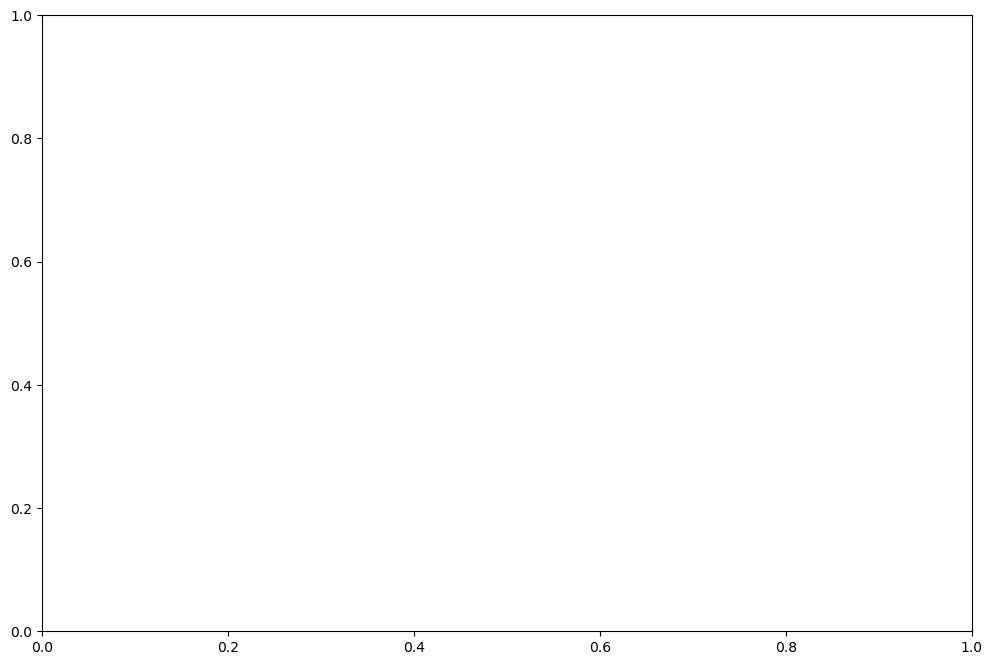

In [73]:
siconc_df = pd.DataFrame(siconc_data)

# plot together
plt.figure(figsize=(12, 8))
for member_id in siconc_df.columns:
    plt.plot(siconc_df.index.values, siconc_df[member_id].values, label=member_id)

plt.title(f'Area-Averaged Sea Ice Concentration for {chosen_model}')
plt.xlabel('Time')
plt.ylabel('Sea Ice Concentration')
plt.legend(title='Ensembles', loc='upper right')
plt.grid(True)
plt.show()

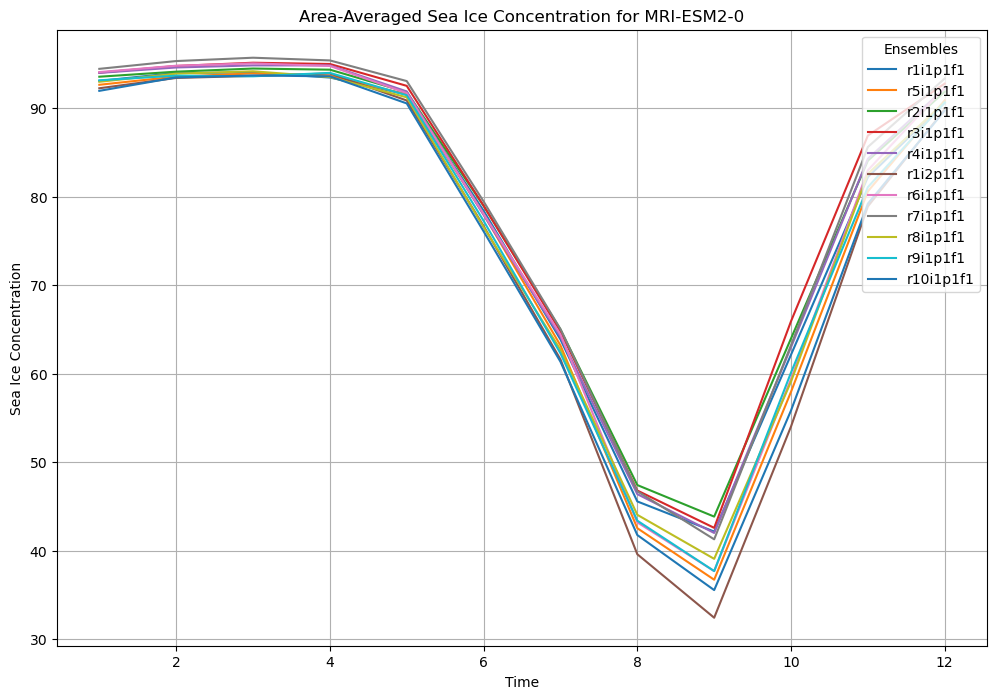

In [13]:
siconc_df.head()
siconc_mean = siconc_df.groupby(siconc_df.index.month).mean()


plt.figure(figsize=(12, 8))
for member_id in siconc_df.columns:
    plt.plot(siconc_mean.index.values, siconc_mean[member_id].values, label=member_id)

plt.title(f'Area-Averaged Sea Ice Concentration for {chosen_model}')
plt.xlabel('Time')
plt.ylabel('Sea Ice Concentration')
plt.legend(title='Ensembles', loc='upper right')
plt.grid(True)
plt.show()



In [38]:
output_dir = "siconc_data"
os.makedirs(output_dir, exist_ok=True)

selected_models = filter_df['Model'].tolist()

# Uncomment to loop through (and indent.)
# for chosen_model in selected_models:
#     print(f"Processing model: {chosen_model}")

chosen_model = "INM-CM5-0"

filtered_ensembles = query.df[query.df['source_id'] == chosen_model]
siconc_data = {}

#loop
for _, row in filtered_ensembles.iterrows():
    member_id = row['member_id']
    dataset_url = row['zstore'] 

    print(f"  Processing ensemble: {member_id}")

    try:
        ds = xr.open_zarr(dataset_url, consolidated=True)

        time = ds['time'].data
        if isinstance(time[0], cftime.datetime):
            time_mask = time >= cftime.DatetimeNoLeap(2000, 1, 1)
        else:
            time_mask = time >= np.datetime64('2000-01-01')

        ds_filtered_time = ds.sel(time=time_mask)

        if 'lat' in ds.coords:
            lat = ds['lat']
        elif 'latitude' in ds.coords:
            lat = ds['latitude']
        elif 'nav_lat' in ds.coords:
            lat = ds['nav_lat']
        else:
            print(f"No latitude variable found for {member_id}. Skipping.")
            continue

        mask = (lat >= 75).compute()
        ds_north_75 = ds_filtered_time.where(mask, drop=True)

        if {'j', 'i'}.issubset(ds_north_75.dims):
            spatial_dims = ['j', 'i']
        elif {'y', 'x'}.issubset(ds_north_75.dims):
            spatial_dims = ['y', 'x']
        elif {'nj', 'ni'}.issubset(ds_north_75.dims):
            spatial_dims = ['nj', 'ni']
        elif {'lat', 'lon'}.issubset(ds_north_75.dims):
            spatial_dims = ['lat', 'lon']
        else:
            print(f"    Unknown spatial dimensions for {member_id}. Skipping.")
            continue

        if 'siconc' in ds_north_75.data_vars:
            siconc_mean = ds_north_75['siconc'].mean(dim=spatial_dims)

            siconc_series = siconc_mean.to_series()
            siconc_data[member_id] = siconc_series
        else:
            print(f"    'siconc' not found for {member_id}. Skipping.")

    except Exception as e:
        print(f"    Failed to process {member_id}: {e}")

siconc_df = pd.DataFrame(siconc_data)

csv_filename = f"{output_dir}/{chosen_model}_siconc.csv"
siconc_df.to_csv(csv_filename, index=True)

print(f"Saved {chosen_model} data to {csv_filename}\n")


  Processing ensemble: r1i1p1f1
  Processing ensemble: r3i1p1f1
  Processing ensemble: r2i1p1f1
  Processing ensemble: r4i1p1f1
  Processing ensemble: r5i1p1f1
  Processing ensemble: r6i1p1f1
  Processing ensemble: r7i1p1f1
  Processing ensemble: r8i1p1f1
  Processing ensemble: r9i1p1f1
  Processing ensemble: r10i1p1f1
Saved INM-CM5-0 data to siconc_data/INM-CM5-0_siconc.csv



In [44]:
chosen_model = "CanESM5"  
chosen_ensemble = "r6i1p1f1"

filtered_ensemble = query.df[
    (query.df['source_id'] == chosen_model) & (query.df['member_id'] == chosen_ensemble)
]
dataset_url = filtered_ensemble.iloc[0]['zstore'] 

ds = xr.open_zarr(dataset_url, consolidated=True)

print("Dataset Dimensions:", ds.dims)
print("Available Coordinates:", ds.coords)


Dataset Dimensions: Frozen({'i': 360, 'j': 291, 'time': 1980, 'bnds': 2, 'vertices': 4})
Available Coordinates: Coordinates:
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 283 284 285 286 287 288 289 290
    latitude   (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    type       |S7 ...


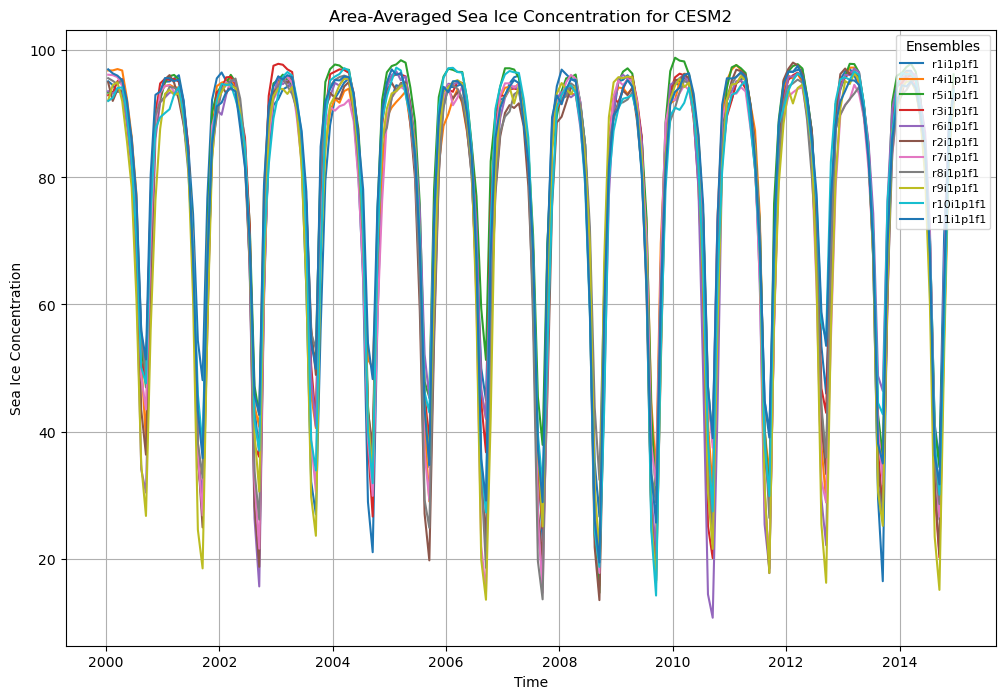

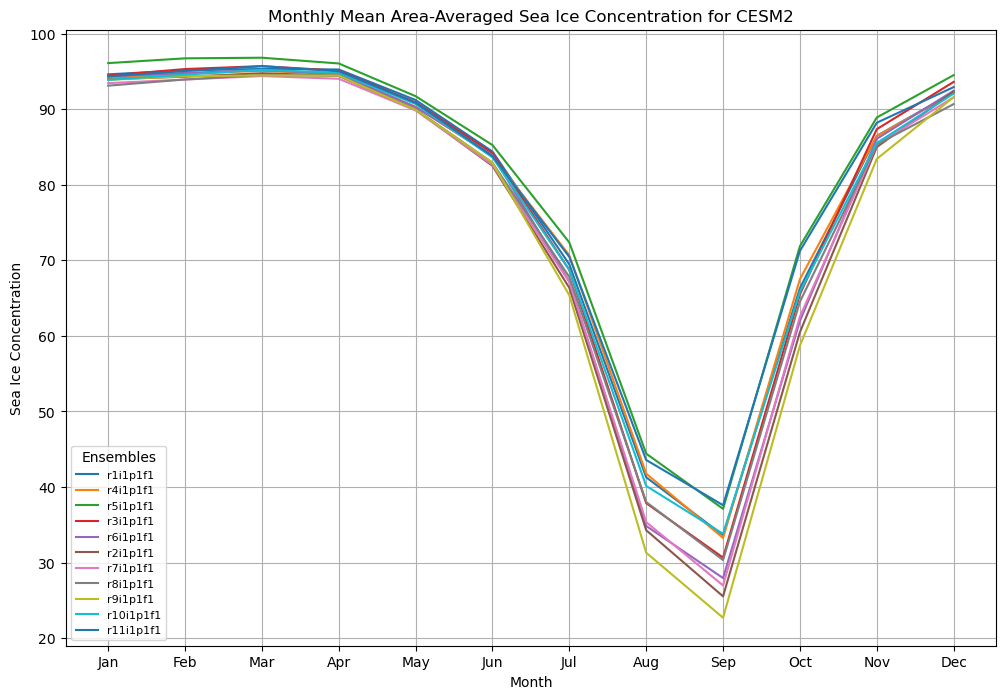

In [75]:
chosen_model = "CESM2" 
csv_filename = f"siconc_data/{chosen_model}_siconc.csv"

siconc_df = pd.read_csv(csv_filename, index_col=0, parse_dates=True)

# area-averaged 
plt.figure(figsize=(12, 8))
for member_id in siconc_df.columns:
    plt.plot(siconc_df.index.values, siconc_df[member_id].values, label=member_id)

plt.title(f'Area-Averaged Sea Ice Concentration for {chosen_model}')
plt.xlabel('Time')
plt.ylabel('Sea Ice Concentration')
plt.legend(title='Ensembles', loc='upper right', fontsize=8)
plt.grid(True)
plt.show()


# monthly mean
siconc_mean = siconc_df.groupby(siconc_df.index.month).mean()

plt.figure(figsize=(12, 8))
for member_id in siconc_df.columns:
    plt.plot(siconc_mean.index.values, siconc_mean[member_id].values, label=member_id)

plt.title(f'Monthly Mean Area-Averaged Sea Ice Concentration for {chosen_model}')
plt.xlabel('Month')
plt.ylabel('Sea Ice Concentration')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Ensembles', loc='lower left', fontsize=8)
plt.grid(True)
plt.show()


mean of mean, variance 
average monthly stdev 
measure of center and measure of range 

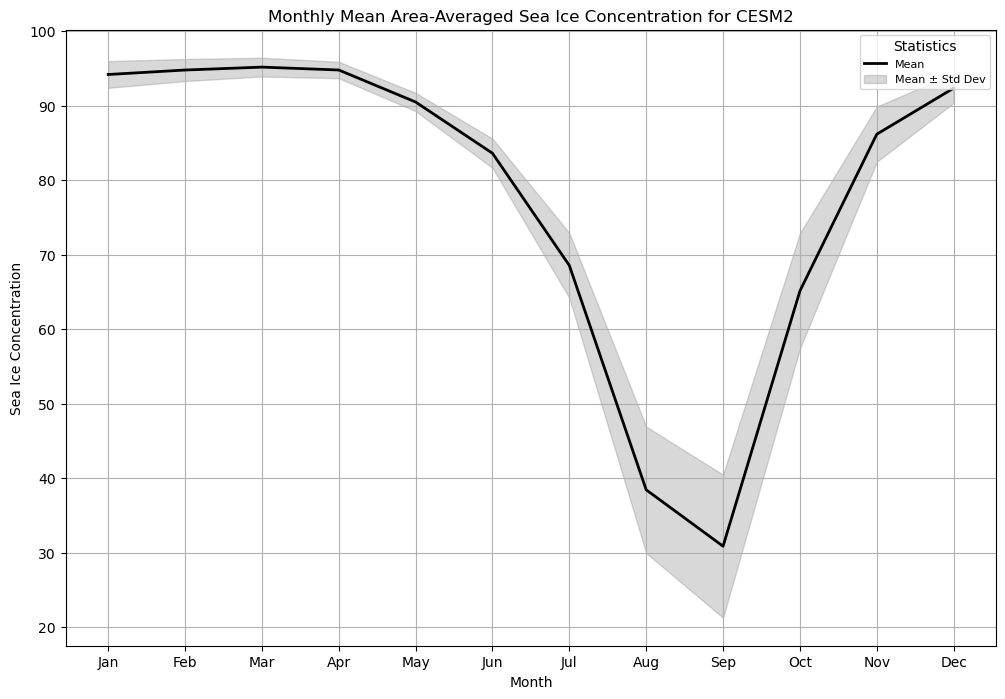

In [68]:
siconc_monthly_mean = siconc_df.groupby(siconc_df.index.month).mean()
siconc_monthly_std = siconc_df.groupby(siconc_df.index.month).std()

month_values = siconc_monthly_mean.index.to_numpy()
mean_monthly_values = siconc_monthly_mean.mean(axis=1).to_numpy()
std_monthly_values = siconc_monthly_std.mean(axis=1).to_numpy()

plt.figure(figsize=(12, 8))

# individual ensemble monthly means
# for member_id in siconc_df.columns:
    # plt.plot(month_values, siconc_monthly_mean[member_id].values, label=member_id, alpha=0.3)

# overall monthly mean and stdev
plt.plot(month_values, mean_monthly_values, label="Mean", color="black", linewidth=2)
plt.fill_between(month_values, 
                 mean_monthly_values - std_monthly_values,
                 mean_monthly_values + std_monthly_values,
                 color='gray', alpha=0.3, label="Mean ± Std Dev")

plt.title(f'Monthly Mean Area-Averaged Sea Ice Concentration for {chosen_model}')
plt.xlabel('Month')
plt.ylabel('Sea Ice Concentration')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Statistics', loc='upper right', fontsize=8)
plt.grid(True)
plt.show()

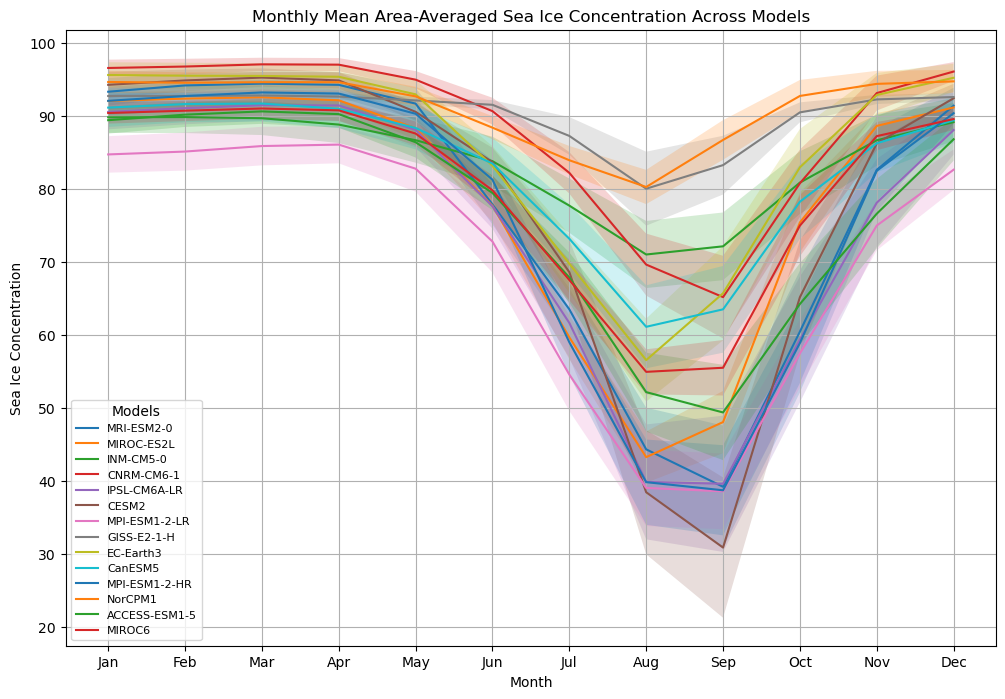

In [74]:
import glob

csv_dir = "siconc_data/"
csv_files = glob.glob(f"{csv_dir}*_siconc.csv")

model_monthly_means = {}
model_monthly_stds = {}

# loop
for csv_file in csv_files:
    model_name = csv_file.split("/")[-1].replace("_siconc.csv", "")
    siconc_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    
    siconc_monthly_mean = siconc_df.groupby(siconc_df.index.month).mean().mean(axis=1)
    siconc_monthly_std = siconc_df.groupby(siconc_df.index.month).std().mean(axis=1)

    # convert to numpy arrays
    siconc_monthly_mean = siconc_monthly_mean.to_numpy()
    siconc_monthly_std = siconc_monthly_std.to_numpy()

    model_monthly_means[model_name] = siconc_monthly_mean
    model_monthly_stds[model_name] = siconc_monthly_std

# convert to dataframes
monthly_means_df = pd.DataFrame(model_monthly_means)
monthly_stds_df = pd.DataFrame(model_monthly_stds)

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_values = np.arange(1, 13) 

plt.figure(figsize=(12, 8))

for model_name in monthly_means_df.columns:
    mean_values = monthly_means_df[model_name].to_numpy()
    std_values = monthly_stds_df[model_name].to_numpy()

    plt.plot(month_values, mean_values, label=model_name)
    plt.fill_between(month_values, mean_values - std_values, mean_values + std_values, alpha=0.2)

plt.title('Monthly Mean Area-Averaged Sea Ice Concentration Across Models')
plt.xlabel('Month')
plt.ylabel('Sea Ice Concentration')
plt.xticks(range(1, 13), month_labels)
plt.legend(title='Models', loc='lower left', fontsize=8)
plt.grid(True)
plt.show()
